In [1]:
%matplotlib inline
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt, colors as mcolors
import os
import shutil
import numpy as np
from scipy import signal

COLORS = [color[0] for color in list(mcolors.TABLEAU_COLORS.items())]

In [2]:
def plott(dfs, columns, labels=None, x='Number of env steps total', smooth=True, kind='line', agg=None): # 'Epoch'
    assert kind in ['line', 'bar']
    if labels is not None:
        assert len(dfs) == len(labels)
        
    if type(agg) is not list:
        agg = [agg] * len(dfs)

    if len(columns) > 2:
        fig, axs = plt.subplots(2,2)
        fig.set_figheight(10)
        fig.set_figwidth(15)
    else:
        fig, axs = plt.subplots(1,2)
        fig.set_figheight(5)
        fig.set_figwidth(15)

    for i, column in enumerate(columns):    
        for j, df in enumerate(dfs):
            if column not in df.columns:
                continue
            if len(columns) > 2:
                axspos = axs[int(i/2), int(i%2)]
            else:
                axspos = axs[i]

            axspos.set_axisbelow(True)
            axspos.grid(color='gray', linestyle='dashed')
            axspos.grid(color='gray', linestyle='dashed')
            axspos.locator_params(axis='y', nbins=18)

            if kind == 'line':
                apply_smooth = smooth and len(df[x]) > 100
                if apply_smooth:
                    axspos.plot(df[x], signal.savgol_filter(df[column], 51, 11), figure=fig, color=COLORS[j % len(COLORS)], label=labels[j])
                axspos.plot(df[x], df[column], figure=fig, alpha=0.2 if apply_smooth else 1, color=COLORS[j % len(COLORS)], label=None if apply_smooth else labels[j])
            else:
                axspos.bar(j, df[x].mean() if agg[i] is None or agg[i] == 'mean' else df[x].max() / 3600, figure=fig, color=COLORS[j % len(COLORS)], label=labels[j])
            axspos.legend(loc='upper right')
            axspos.set_title(column)

In [3]:
REMOVE_BELOW_STEPS = 100000
progresses = []

for dirname, _, filenames in os.walk('output'):
    for filename in filenames:
        if 'progress' in filename:
            file = os.path.join(dirname, filename)

            try:
                tempdf = pd.read_csv(file)
            except pd.errors.EmptyDataError as e:
                shutil.rmtree(dirname, ignore_errors=True)
                print('Removed empty folder', dirname)
                continue

            steps = tempdf['Number of env steps total'].iloc[-1]
            if steps < REMOVE_BELOW_STEPS:
                shutil.rmtree(dirname, ignore_errors=True)
                print('Removed small experiment (', steps, ' steps)', dirname)
                continue
                
            progresses.append(file)

progresses.sort()
for i, progress in enumerate(progresses):
    print(i, progress)

Removed empty folder output/reach-ml1/2020_04_08_22_56_54
Removed empty folder output/reach-ml1/2020_04_06_21_22_04
Removed empty folder output/reach-ml1/2020_04_08_22_45_29
Removed small experiment ( 1950  steps) output/reach-ml1/2020_04_06_21_15_54
0 output/cheetah-vel/2020_02_16_00_49_55/progress.csv
1 output/cheetah-vel/2020_02_17_18_09_55/progress.csv
2 output/cheetah-vel/2020_03_03_16_20_26/progress.csv
3 output/cheetah-vel/2020_03_04_17_23_41/progress.csv
4 output/cheetah-vel/2020_03_05_23_41_01/progress.csv
5 output/cheetah-vel/2020_03_06_13_23_33/progress.csv
6 output/cheetah-vel/2020_03_07_17_09_05/progress.csv
7 output/cheetah-vel/2020_03_07_23_12_39/progress.csv
8 output/cheetah-vel/2020_03_17_00_33_59/progress.csv
9 output/cheetah-vel/2020_03_26_04_30_37/progress.csv
10 output/cheetah-vel/2020_03_26_04_34_42/progress.csv
11 output/cheetah-vel/2020_03_27_00_51_58/progress.csv
12 output/cheetah-vel/2020_03_29_22_24_16/progress.csv
13 output/pick-place-ml1/2020_02_15_02_00_11

In [7]:
results = [
    #('Int. Obs', pd.read_csv(progresses[0], skiprows=[1])),
    #('Int. Ctx', pd.read_csv(progresses[1], skiprows=[1])),
    ('PEARL', pd.read_csv(progresses[2], skiprows=[1], nrows=100)),
    ('PEARL 2', pd.read_csv(progresses[3], skiprows=[1])),
    ('Int. Ctx', pd.read_csv(progresses[4], skiprows=[1])),
    #('Ctx Only Grads', pd.read_csv(progresses[5], skiprows=[1])),
    #('Int. Ctx 3', pd.read_csv(progresses[6], skiprows=[1])),
    #('Int. Ctx 4', pd.read_csv(progresses[7], skiprows=[1])),
    #('L2 0.1', pd.read_csv(progresses[8], skiprows=[1])),
    #('Dropout', pd.read_csv(progresses[9], skiprows=[1])),
    ('L2 0.01', pd.read_csv(progresses[10], skiprows=[1])),
    ('L2 0.01 2', pd.read_csv(progresses[11], skiprows=[1])),
    ('PEARL', pd.read_csv(progresses[12], skiprows=[1], nrows=100)),
    #('Normalized', pd.read_csv(progresses[16], skiprows=[1])),
]

for i, (label, df) in enumerate(results):
    if label == 'PEARL' and 'Mean Intrinsic Reward' in df.columns:
        label = 'Intrinsic'
        results[i] = (label, df)
    
    hours = '%.2f' % float(df['Total Train Time (s)'].iloc[-1] / 60 / 60)
    print('Results ' + str(i) + ' (' + label + '): ', df['Number of env steps total'].iloc[-1], ' steps in ', hours, 'hours')
    
results[0][1].columns

Results 0 (PEARL):  705000  steps in  4.33 hours
Results 1 (PEARL 2):  1440000  steps in  10.29 hours
Results 2 (Int. Ctx):  1500000  steps in  12.30 hours
Results 3 (L2 0.01):  1085000  steps in  11.03 hours
Results 4 (L2 0.01 2):  1735000  steps in  18.62 hours
Results 5 (PEARL):  350000  steps in  1.24 hours


Index(['Z mean train', 'Z variance train', 'KL Divergence', 'KL Loss',
       'QF Loss', 'VF Loss', 'Policy Loss', 'Q Predictions Mean',
       'Q Predictions Std', 'Q Predictions Max', 'Q Predictions Min',
       'V Predictions Mean', 'V Predictions Std', 'V Predictions Max',
       'V Predictions Min', 'Log Pis Mean', 'Log Pis Std', 'Log Pis Max',
       'Log Pis Min', 'Policy mu Mean', 'Policy mu Std', 'Policy mu Max',
       'Policy mu Min', 'Policy log std Mean', 'Policy log std Std',
       'Policy log std Max', 'Policy log std Min', 'Z mean eval',
       'Z variance eval', 'AverageTrainReturn_all_train_tasks',
       'AverageReturn_all_train_tasks', 'AverageReturn_all_test_tasks',
       'Number of train steps total', 'Number of env steps total',
       'Number of rollouts total', 'Train Time (s)',
       '(Previous) Eval Time (s)', 'Sample Time (s)', 'Epoch Time (s)',
       'Total Train Time (s)', 'Epoch'],
      dtype='object')

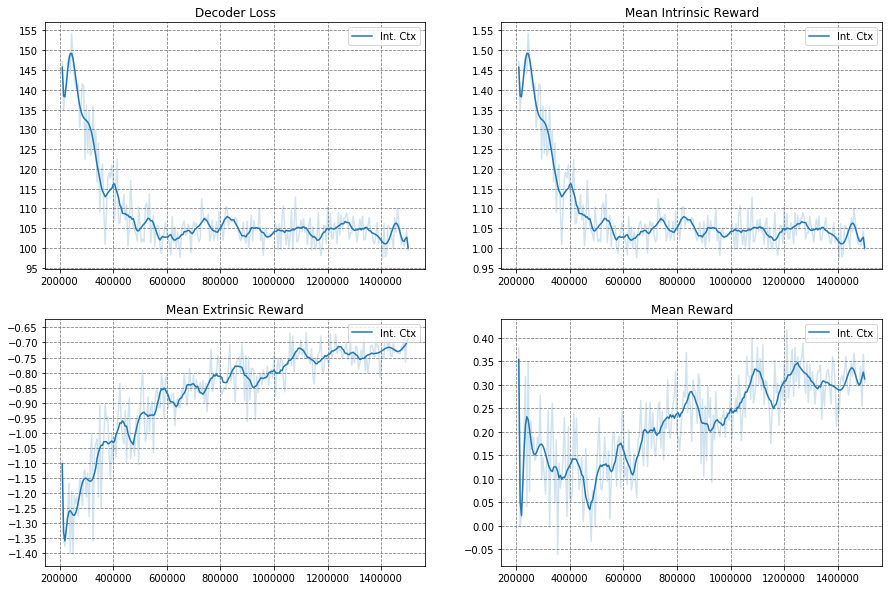

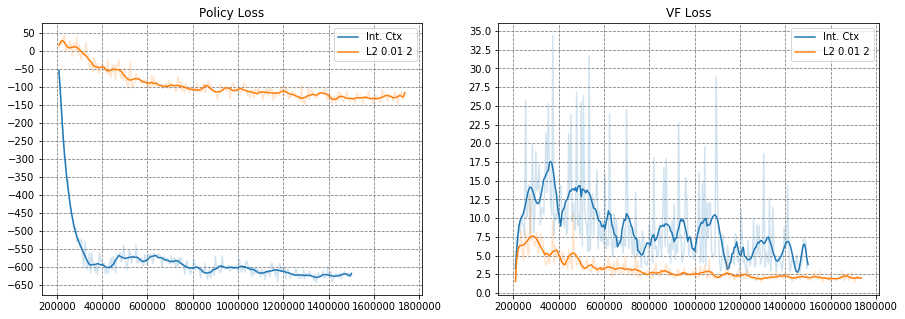

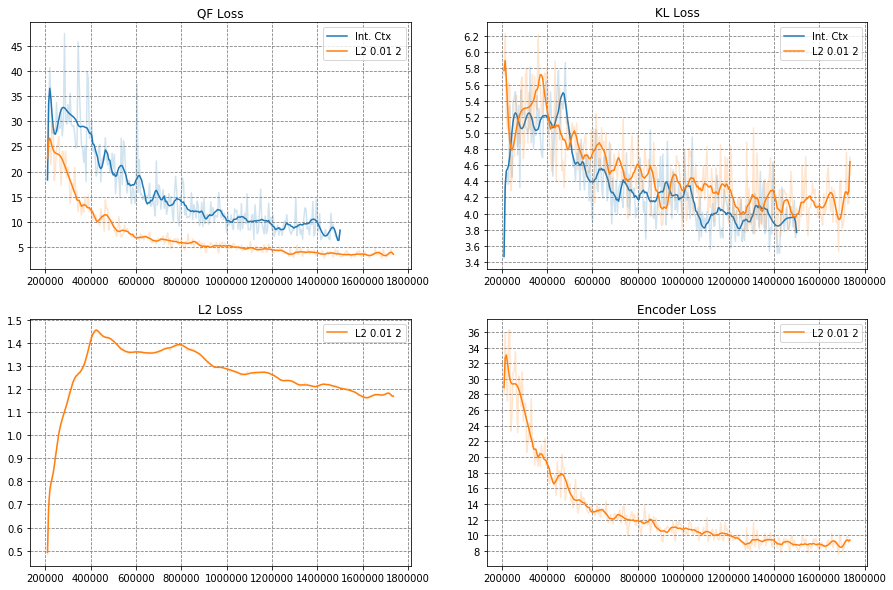

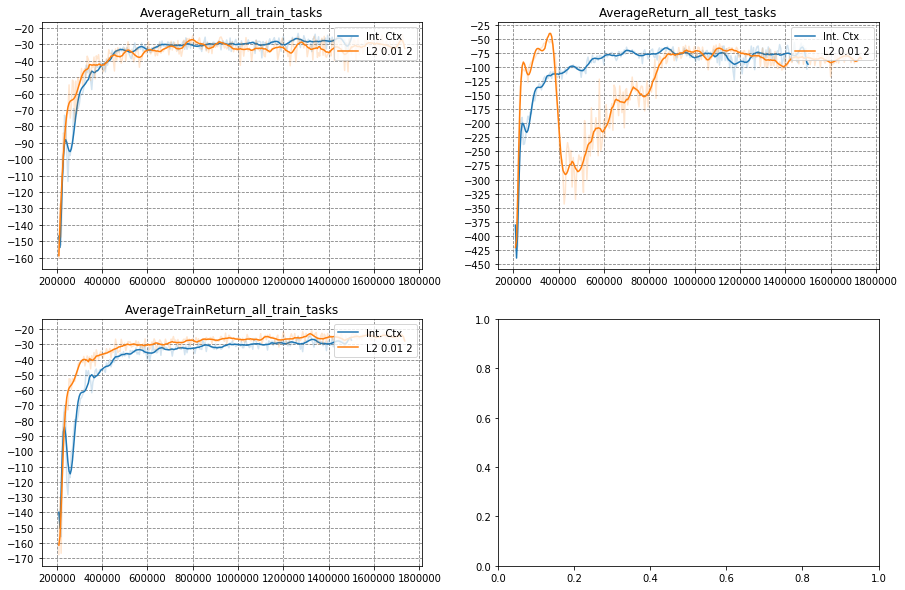

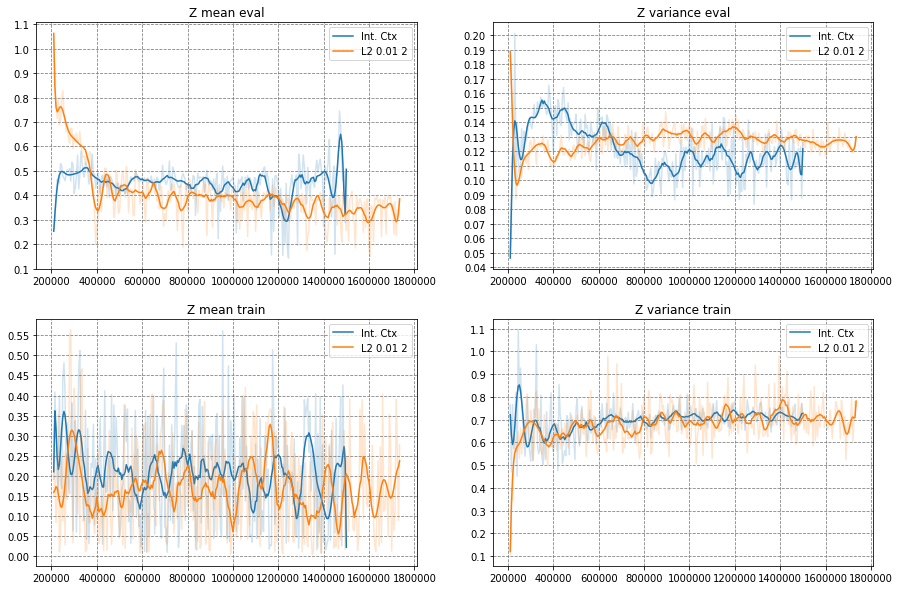

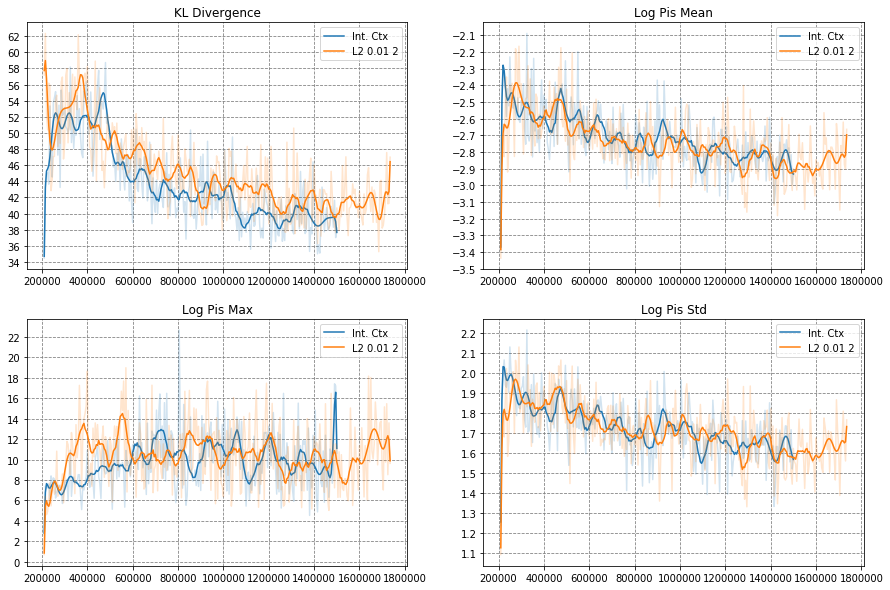

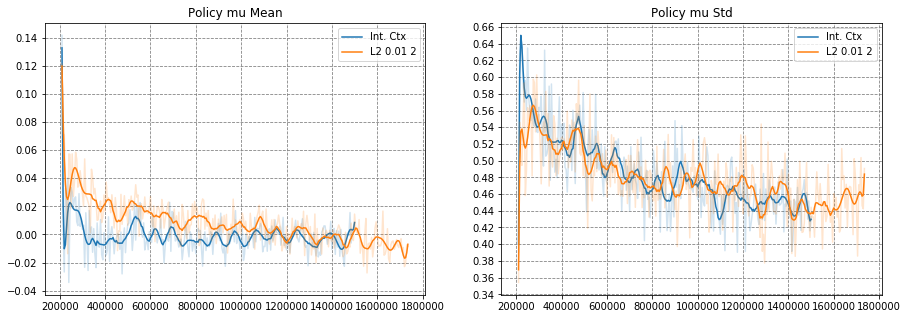

In [9]:
dfs = [df for _, df in results]
labels = [label for label, _ in results]
#plott(dfs, ['Total Train Time (s)', 'Train Time (s)', 'Sample Time (s)', 'Epoch Time (s)'], labels, kind='bar', agg=['max', 'mean', 'mean', 'mean'])
plott(dfs, ['Decoder Loss', 'Mean Intrinsic Reward', 'Mean Extrinsic Reward', 'Mean Reward'], labels)
plott(dfs, ['Policy Loss', 'VF Loss'], labels)
plott(dfs, ['QF Loss', 'KL Loss', 'L2 Loss', 'Encoder Loss'], labels)
plott(dfs, ['AverageReturn_all_train_tasks', 'AverageReturn_all_test_tasks', 'AverageTrainReturn_all_train_tasks'], labels), # 'Mean Extrinsic Reward'
plott(dfs, ['Z mean eval', 'Z variance eval', 'Z mean train', 'Z variance train'], labels)
plott(dfs, ['KL Divergence', 'Log Pis Mean', 'Log Pis Max', 'Log Pis Std'], labels) # 'Latent Entropy'
plott(dfs, ['Policy mu Mean', 'Policy mu Std'], labels)